<a href="https://colab.research.google.com/github/ajitjadhav10/Personal-Projects/blob/main/News%20Summarization%20Application/EDA_and_Streamlit_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN/Daily Mail news data EDA and Streamlit application code

## About the Project and the Dataset

>Today, users are shifting from consuming news on traditional platforms like television and print media to digital news platforms and social media. As the amount of news available on digital platforms is increasing rapidly, summarization of news has become essential. News summary presents the users with easy-to-understand text while maintaining the context of the information, and this allows users to read the news and understand the context of the situation in a short duration. In this work, we have built an abstractive news summarization application on Streamlit using a fine-tuned T5 transformer model. The T5 transformer model has been fine-tuned on the CNN-Dailymail dataset which contains more than 300K news articles and their summaries before developing the summarization application. Below is the Exploratory Data Analysis on CNN/Daily Mail News articles which contains the News text and the summary generated by humans.  



## Importing all the Libraries. 

In [ ]:
# importing all the libraries.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import FreqDist
import scipy.stats as stats
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# calling the dataset.

data = pd.read_csv('/content/test_2_edited.csv')

In [ ]:
data.head(3)

,text,ctext
0,Experts question if packed out planes are put...,Ever noticed how plane seats appear to be gett...
1,Drunk teenage boy climbed into lion enclosure ...,A drunk teenage boy had to be rescued by secur...
2,Nottingham Forest are close to extending Dougi...,Dougie Freedman is on the verge of agreeing a ...


In [ ]:
text = " ".join(ctext for ctext in data.ctext)
print ("There are {} words in the combination of all text.".format(len(text)))

There are 45593213 words in the combination of all text.


## Functions for Data Preprocessing

In [ ]:
### Defining all the required functions for data cleaning and preprocessing. 


#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)



#Tokenization of text
tokenizer=ToktokTokenizer()


#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
new_stopwords = ["said","say","says"]
stopword_list.extend(new_stopwords)


#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Lemmatizing the sentences. 
lemmatizer = WordNetLemmatizer()
def tag_to_wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


## Data Preprocessing and Cleaning
 

In [ ]:
## Applying the functions on the text column.

data['text'] = data['text'].apply(remove_between_square_brackets)
data['text'] = data['text'].apply(remove_stopwords)
data['text'] = data['text'].apply(remove_special_characters)

data['text'] = data['text'].apply(lambda x:
' '.join([w for w in x.split() if len(w)>2]))
data['text'] = data['text'].str.lower()

data['text'] = data['text'].apply(lambda x: lemmatize_sentence(x))

## Applying the functions on the ctext column.

data['ctext'] = data['ctext'].apply(remove_between_square_brackets)
data['ctext'] = data['ctext'].apply(remove_stopwords)
data['ctext'] = data['ctext'].apply(remove_special_characters)

data['ctext'] = data['ctext'].apply(lambda x:
' '.join([w for w in x.split() if len(w)>2]))
data['ctext'] = data['ctext'].str.lower()

data['ctext'] = data['ctext'].apply(lambda x: lemmatize_sentence(x))






In [ ]:
data.to_csv('preprocessed_data.csv')

### Visualizing Most Frequent words

In [ ]:
text1 = " ".join(text for text in data.text)

text1 = text1.split()
words_df1 = FreqDist(text1)
words_df1 = pd.DataFrame({'word':list(words_df1.keys()), 'count':list(words_df1.values())})

text2 = " ".join(ctext for ctext in data.ctext)

text2 = text2.split()
words_df2 = FreqDist(text2)
words_df2 = pd.DataFrame({'word':list(words_df2.keys()), 'count':list(words_df2.values())})





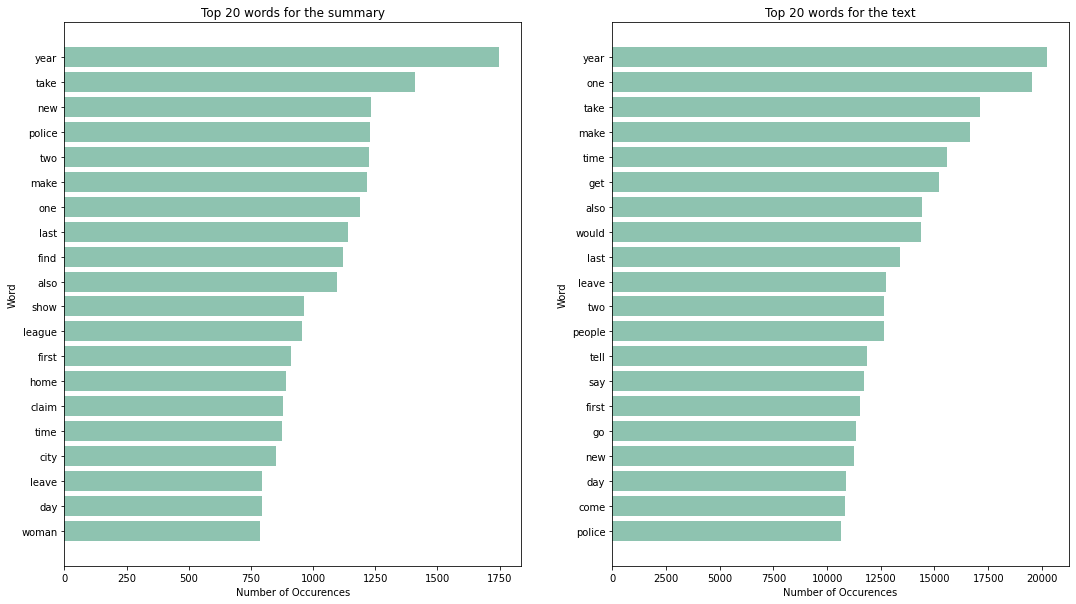

In [ ]:
words_df1 = words_df1.nlargest(columns="count", n = 20) 
words_df1.sort_values('count', inplace = True)

words_df2 = words_df2.nlargest(columns="count", n = 20) 
words_df2.sort_values('count', inplace = True)

# Plotting 20 frequent words

plt.figure(figsize=(18,10))
plt.tight_layout(pad = 1.0)
plt.subplot(1,2,1)
plt.barh(words_df1['word'], width = words_df1['count'],color = '#8EC3B0')
plt.title('Top 20 words for the summary')
plt.xlabel('Number of Occurences')
plt.ylabel('Word')
# Plotting 20 frequent words
plt.subplot(1,2,2)
plt.barh(words_df2['word'], width = words_df2['count'],color = '#8EC3B0')
plt.title('Top 20 words for the text')
plt.xlabel('Number of Occurences')
plt.ylabel('Word')
plt.show()

In [ ]:
#saving them into csv for accesing quickly in the streamlit code. 

words_df2.to_csv('top_20_text.csv')
words_df1.to_csv('top_20_summary_text.csv')


### Plotting the Word Clouds

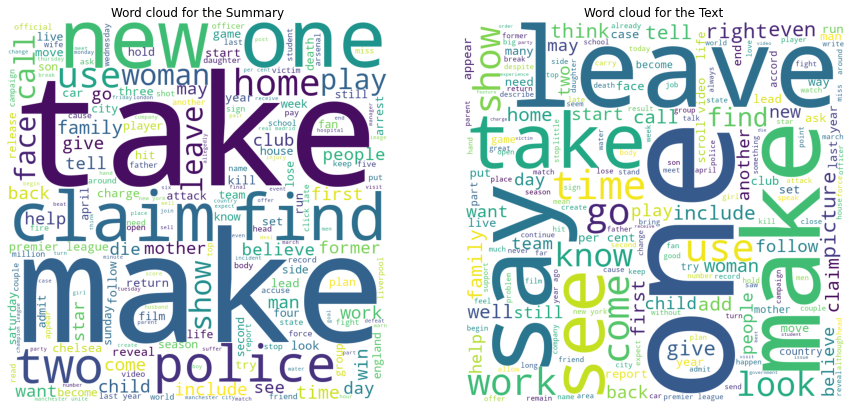

In [ ]:
from wordcloud import WordCloud


#plot the WordCloud image for the summary.   
all_words1 = ' '.join([text for text in data['text']])

word_cloud1 = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words1)


#plot the WordCloud image for the text.   
all_words2 = ' '.join([text for text in data['ctext']])

word_cloud2 = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words2)

#plot the WordCloud image for the summary.                       
plt.figure(figsize = (15, 15), facecolor = None) 
plt.subplot(1,2,1)
plt.imshow(word_cloud1) 
plt.title('Word cloud for the Summary')
plt.axis("off") 
plt.subplot(1,2,2)
plt.title('Word cloud for the Text')
plt.imshow(word_cloud2)
plt.axis("off") 
plt.show()

## POS-Tagging Using TextBlob Library.

In [ ]:
df = pd.read_csv('/content/test_2_edited.csv')

In [ ]:
reindexed_data = df['text']

In [ ]:
tagged_summary = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [ ]:
tagged_summary_df = pd.DataFrame({'tags':tagged_summary})

word_counts = [] 
pos_counts = {}

for summary in tagged_summary_df[u'tags']:
    word_counts.append(len(summary))
    for tag in summary:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per summary: ', np.mean(word_counts))

Total number of words:  598839
Mean number of words per summary:  52.11827676240209


In [ ]:
tagged_summary_df.to_csv('pos_tagging_CNN.csv')

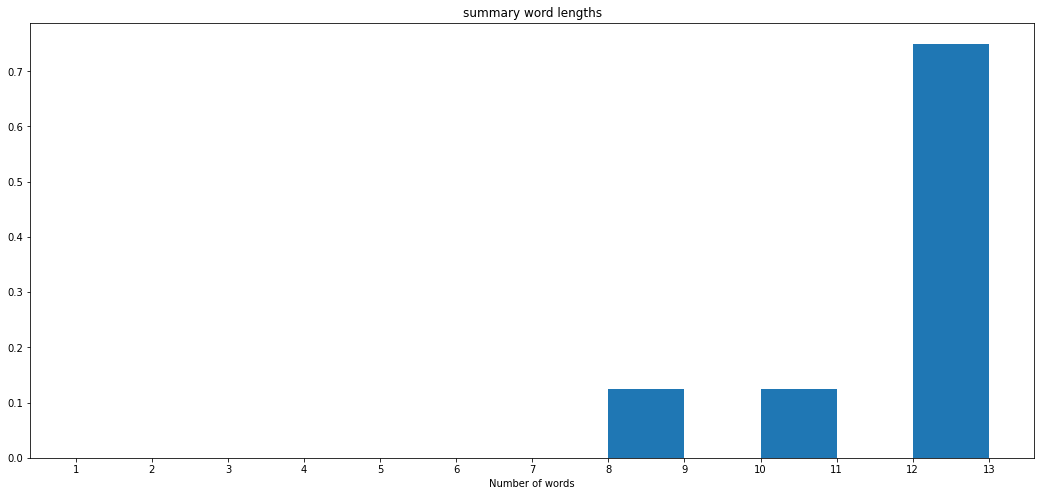

In [ ]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);

ax.set_title('summary word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

Text(0.5, 0, 'Type of Word')

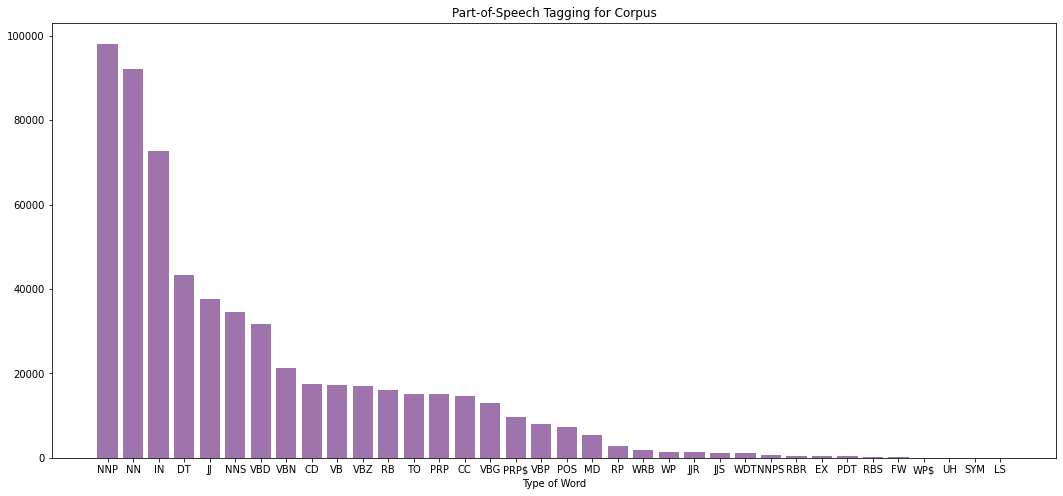

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts,color = '#9F73AB')
ax.set_xticks(range(len(pos_counts)))
ax.set_xticklabels(pos_sorted_types)
ax.set_title('Part-of-Speech Tagging for Corpus')
ax.set_xlabel('Type of Word')

## Topic Modelling using LDA.

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words=stopword_list, max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('News before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('News after vectorization: \n{}'.format(small_document_term_matrix[123]))

News before vectorization: Going online has become the path of least resistance if you want to make yourself heard .
But where there is the restrictive rule of law, journalists are vulnerable to the anger of officialdom .
From China to Malaysia, journalists and bloggers have been jailed -- even killed .
News after vectorization: 
  (0, 18274)	1
  (0, 21784)	1
  (0, 17289)	1
  (0, 21067)	1
  (0, 17193)	1
  (0, 15760)	1
  (0, 31443)	1
  (0, 31559)	1
  (0, 6366)	1
  (0, 12995)	1
  (0, 10838)	1
  (0, 16573)	1
  (0, 3851)	1
  (0, 24572)	1
  (0, 13943)	1
  (0, 24634)	1
  (0, 25278)	1
  (0, 16110)	2
  (0, 2443)	1
  (0, 20957)	1
  (0, 18295)	1
  (0, 4412)	1


In [ ]:
n_topics = 10

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  new sterling year also liverpool video prince old set week
Topic 2:  year england old test first world former cook anderson five
Topic 3:  hamilton rosberg grand prix lewis second nico mercedes world chinese
Topic 4:  new year per cent 000 world first murray open two
Topic 5:  league manchester united city season chelsea premier liverpool year scored
Topic 6:  year new one 000 also would two people years could
Topic 7:  year old two mother police found last years three family
Topic 8:  police year old found man two home arrested one court
Topic 9:  arsenal final cup league bayern liverpool fa year champions face
Topic 10:  school women year isis two students new video one day


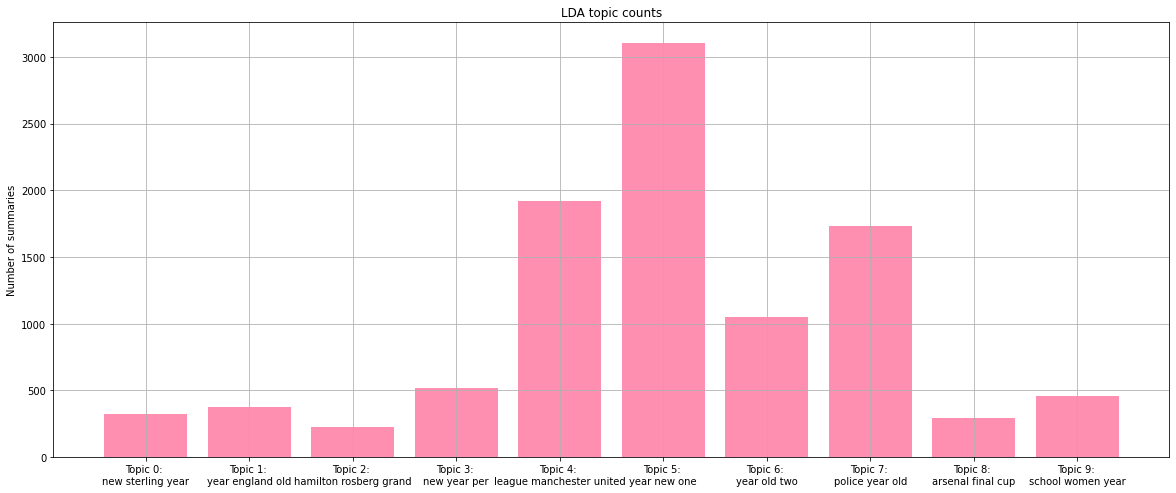

In [ ]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]


fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lda_categories, lda_counts,color = '#FF8FB1')
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of summaries')
plt.grid()

In [ ]:
top_3_words

['new sterling year',
 'year england old',
 'hamilton rosberg grand',
 'new year per',
 'league manchester united',
 'year new one',
 'year old two',
 'police year old',
 'arsenal final cup',
 'school women year']

In [ ]:
#installing streamlit for the user interface
!pip install streamlit -q

     |████████████████████████████████| 9.2 MB 30.5 MB/s 
     |████████████████████████████████| 237 kB 65.7 MB/s 
     |████████████████████████████████| 164 kB 70.9 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 4.7 MB 41.4 MB/s 
     |████████████████████████████████| 182 kB 64.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 


In [ ]:

#installing newspaper3k library for extracting text from rss feed.
!pip install newspaper3k -q

     |████████████████████████████████| 211 kB 10.4 MB/s 
     |████████████████████████████████| 7.4 MB 16.4 MB/s 
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 


In [ ]:
!pip install -qq transformers
!pip install -qq torch
!pip install -qq sentencepiece

     |████████████████████████████████| 5.8 MB 23.7 MB/s 
     |████████████████████████████████| 182 kB 72.1 MB/s 
     |████████████████████████████████| 7.6 MB 63.6 MB/s 
     |████████████████████████████████| 1.3 MB 27.9 MB/s 


In [ ]:
#installing newspaper3k library for extracting text from rss feed.
!pip install newspaper3k -q

##News Shack


> In this research, we have developed ‘News Shack’ an abstractive news summarization web application using Streamlit. This application allows users to gather summaries of the latest news from Google RSS feed based on different categories. It also allows users to fetch news summaries of their favorite topics. Furthermore, it provides users with an option to select the number of articles they would like to summarize. Hence, this application can be extremely valuable for users who consume news through digital platforms but at the same time, want to read news from reliable sources.







###Code for Streamlit.

In [ ]:
%%writefile NLP_Project_AppEDA.py

import streamlit as st
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import FreqDist
import scipy.stats as stats
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
# Data scraping libraries
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen
from newspaper import Article
import io
#T5 libraries
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForSeq2SeqLM
#########################################################################################################################################################
st.set_page_config(page_title='News Shack📰', page_icon='./Meta/newspaper.ico')

#function to fetch the news from rss feed of google news api
def fetch_news_search_topic(topic):
    site = 'https://news.google.com/rss/search?q={}'.format(topic)
    op = urlopen(site)  # Open that site
    rd = op.read()  # read data from site
    op.close()  # close the object
    sp_page = soup(rd, 'xml')  # scrapping data from site
    news_list = sp_page.find_all('item')  # finding news
    return news_list

#function to fetch the top news from rss feed of google news api
def fetch_top_news():
    site = 'https://news.google.com/news/rss'
    op = urlopen(site)  # Open that site
    rd = op.read()  # read data from site
    op.close()  # close the object
    sp_page = soup(rd, 'xml')  # scrapping data from site
    news_list = sp_page.find_all('item')  # finding news
    return news_list

#function to fetch the topic wise news from rss feed of google news api
def fetch_category_news(topic):
    site = 'https://news.google.com/news/rss/headlines/section/topic/{}'.format(topic)
    op = urlopen(site)  # Open that site
    rd = op.read()  # read data from site
    op.close()  # close the object
    sp_page = soup(rd, 'xml')  # scrapping data from site
    news_list = sp_page.find_all('item')  # finding news
    return news_list


def fetch_news_poster(poster_link):
    try:
        u = urlopen(poster_link)
        raw_data = u.read()
        image = Image.open(io.BytesIO(raw_data))
        st.image(image, use_column_width=True)
    except:
        image = Image.open('/content/sample_data/Breaking_News.jpeg')
        st.image(image, use_column_width=True)

#function to summarize through T5 model and display the news
def display_news(list_of_news, news_quantity):
    c = 0
    for news in list_of_news:
        c += 1
        # st.markdown(f"({c})[ {news.title.text}]({news.link.text})")
        st.write('**({}) {}**'.format(c, news.title.text))
        news_data = Article(news.link.text)
        try:
            news_data.download()
            news_data.parse()
            title = news_data.title
            text = news_data.text
            tokenizer = AutoTokenizer.from_pretrained("ajitjadhav/t5-small-finetuned-t5-summarization")
            model = AutoModelForSeq2SeqLM.from_pretrained("ajitjadhav/t5-small-finetuned-t5-summarization")
            device = torch.device('cpu')
          
            preprocess_text = text.strip().replace("\n","")
            t5_prepared_Text = "summarize: "+preprocess_text

            tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)


            # summmarize 
            summary_ids = model.generate(tokenized_text,
                                                num_beams=1,
                                                no_repeat_ngram_size=2,
                                                min_length=30,
                                                max_length=100,
                                                early_stopping=True)

            news_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)



        except Exception as e:
            st.error(e)
        fetch_news_poster(news_data.top_image)
        with st.expander(news.title.text):
            st.markdown(
                '''<h6 style='text-align: justify;'>{}"</h6>'''.format(news_summary),
                unsafe_allow_html=True)
            st.markdown("[Read more at {}...]({})".format(news.source.text, news.link.text))
        st.success("Published Date: " + news.pubDate.text)
        if c >= news_quantity:
            break

###########################################################################################################################################################


## Functions for Data Visualizations.
df = pd.read_csv('/content/test_2_edited.csv')
reindexed_data = df['text']
tagged_summary = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]
tagged_summary_df = pd.DataFrame({'tags':tagged_summary})
word_counts = [] 
pos_counts = {}
for summary in tagged_summary_df[u'tags']:
    word_counts.append(len(summary))
    for tag in summary:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
new_stopwords = ["said","say","says"]
stopword_list.extend(new_stopwords)

pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)
small_count_vectorizer = CountVectorizer(stop_words=stopword_list, max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
n_topics = 10

# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
# Define helper functions

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

# using LDA model for topic modelling. 

lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                        random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)

# calling the dataset. 
data = pd.read_csv('/content/preprocessed_data.csv')

#plot the WordCloud image for the summary and text.   

all_words1 = ' '.join([text for text in data['text']])
word_cloud1 = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(all_words1)
all_words2 = ' '.join([text for text in data['ctext']])
word_cloud2 = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        min_font_size = 10).generate(all_words2)
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]


#### The run function to run everything on steamlit.

def run():
    col = st.sidebar.radio('News Options:',['About Us','Google News','Data Visualizations', 'Text Summarization'])
    if col == 'About Us':
      st.title('News Shack: Inshorts 📰') 
      image = Image.open('/content/sample_data/News.jpg')
      col1, col2, col3 = st.columns([3, 5, 8])
      with col1:
          st.write("")
      with col2:
          st.image(image, use_column_width='auto')
      with col3:
          st.write("")

      st.markdown("In this research, we developed ‘News Shack,’ an abstractive news summarization web application using Streamlit. This application allows users to gather gather summaries of the latest news from Google RSS feed based on different categories. It also allows users to fetch news summaries of their favorite topics. Furthermore, it provides users with an option to select the number of articles they would like to summarize. Hence, this application can be extremely valuable for users who consume news through digital platforms but at the same time, want to read news from reliable sources")

    if col == 'Google News':
      st.title('Google News')
      category = ['--Select--', 'Trending News🔥', 'Favourite Topics💙', 'Search Topic🔍']
      cat_op = st.selectbox('Select your Category', category)
      if cat_op == category[0]:
          st.warning('Please select Type!!')
      elif cat_op == category[1]:
          st.subheader("✅ Here is the Trending news for you")
          no_of_news = st.slider('Number of News:', min_value=5, max_value=25, step=1)
          news_list = fetch_top_news()
          display_news(news_list, no_of_news)
      elif cat_op == category[2]:
          av_topics = ['Choose Topic', 'WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SPORTS', 'SCIENCE',
                      'HEALTH']
          st.subheader("Choose your favourite Topic")
          chosen_topic = st.selectbox("Choose your favourite Topic", av_topics)
          if chosen_topic == av_topics[0]:
              st.warning("Please Choose the Topic")
          else:
              no_of_news = st.slider('Number of News:', min_value=5, max_value=25, step=1)
              news_list = fetch_category_news(chosen_topic)
              if news_list:
                  st.subheader("✅ Here are the some {} News for you".format(chosen_topic))
                  display_news(news_list, no_of_news)
              else:
                  st.error("No News found for {}".format(chosen_topic))

      elif cat_op == category[3]:
          user_topic = st.text_input("Enter your Topic🔍")
          no_of_news = st.slider('Number of News:', min_value=5, max_value=15, step=1)

          if st.button("Search") and user_topic != '':
              user_topic_pr = user_topic.replace(' ', '')
              news_list = fetch_news_search_topic(topic=user_topic_pr)
              if news_list:
                  st.subheader("✅ Here are the some {} News for you".format(user_topic.capitalize()))
                  display_news(news_list, no_of_news)
              else:
                  st.error("No News found for {}".format(user_topic))
          else:
              st.warning("Please write Topic Name to Search🔍")

    if col == 'Data Visualizations':
      st.title('Exploratory Data Analysis on the CNN/ Daily Mail Dataset')
      tab1,tab2,tab3,tab4 = st.tabs(["Top 20 Most Frequent words","Word Cloud","POS-Tagging","Topic Modelling"])
      with tab1:
        words_df1 = pd.read_csv('/content/top_20_summary_text.csv')
        words_df2 = pd.read_csv('/content/top_20_text.csv')
        st.text("Finding the most frequent words for human generated summary and actual text. ")
        col1,col2 = st.columns(2)
        with col1:
          # caling figure 1 for summary text.
          fig1 = plt.figure(figsize=(10,6))
          plt.tight_layout(pad = 1.0)
          plt.subplot(1,2,1)
          plt.barh(words_df1['word'], width = words_df1['count'],color = '#8EC3B0')
          plt.title('Top 20 words for the summary')
          plt.xlabel('Number of Occurences')
          plt.ylabel('Word')
          st.pyplot(fig1)
          
        with col2:
          # caling figure 1 for the whole text.
          fig2 = plt.figure(figsize=(10,6))
          plt.subplot(1,2,2)
          plt.barh(words_df2['word'], width = words_df2['count'],color = '#8EC3B0')
          plt.title('Top 20 words for the text')
          plt.xlabel('Number of Occurences')
          plt.ylabel('Word')
          st.pyplot(fig2)
      with tab2:
        st.text(" Word clouds to see the similarity between the two.")
        col1,col2 = st.columns(2)
        with col1:
          #plot the WordCloud image for the summary.                       
          wc1 = plt.figure(figsize = (15, 15), facecolor = None) 
          plt.subplot(1,2,1)
          plt.imshow(word_cloud1) 
          plt.title('Word cloud for the Summary')
          plt.axis("off")
          st.pyplot(wc1)             
        with col2:
          #plot the WordCloud image for the text.
          wc2 = plt.figure(figsize = (15, 15), facecolor = None) 
          plt.subplot(1,2,2)
          plt.title('Word cloud for the Text')
          plt.imshow(word_cloud2)
          plt.axis("off") 
          st.pyplot(wc2)
        with tab3:
          st.text("Part of speech tagging for arranging the words in their lexical categories. ")
          fig, ax = plt.subplots(figsize=(18,8))
          ax.bar(range(len(pos_counts)), pos_sorted_counts,color = '#9F73AB')
          ax.set_xticks(range(len(pos_counts)))
          ax.set_xticklabels(pos_sorted_types)
          ax.set_title('Part-of-Speech Tagging for Corpus')
          ax.set_xlabel('Type of Word')
          st.pyplot(fig)


        with tab4:
          st.text("Topic Modellinng Using Latent Dirichlet Allocation(LDA).")
          fig, ax = plt.subplots(figsize=(20,8))
          ax.bar(lda_categories, lda_counts,color = '#FF8FB1')
          ax.set_xticks(lda_categories)
          ax.set_xticklabels(labels)
          ax.set_title('LDA topic counts')
          ax.set_ylabel('Number of summaries')
          plt.grid()
          st.pyplot(fig)
          
        

      if col == 'Text Summarization':
        tokenizer = AutoTokenizer.from_pretrained("ajitjadhav/t5-small-finetuned-t5-summarization")
        model = AutoModelForSeq2SeqLM.from_pretrained("ajitjadhav/t5-small-finetuned-t5-summarization")
        device = torch.device('cpu')
        text = st.text_area('Enter Text Below (maximum 800 words):', height=300) 
        submit = st.button('Generate')  

        if submit:

            st.subheader("Summary:")

            with st.spinner(text="This may take a moment..."):

                preprocess_text = text.strip().replace("\n","")
                t5_prepared_Text = "summarize: "+preprocess_text

                tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

                summary_ids = model.generate(tokenized_text,num_beams=1,no_repeat_ngram_size=2,min_length=30,max_length=60,early_stopping=True)

                output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            st.write(output)






        
    
    
run()

Overwriting NLP_Project_AppEDA.py


In [ ]:
!streamlit run NLP_Project_AppEDA.py & npx localtunnel --port 8501

[#######...........] - extract:localtunnel: verb lock using /root/.npm/_locks/s


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.170.205:8501

npx: installed 22 in 3.148s
your url is: https://smooth-paths-brake-35-245-170-205.loca.lt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2022-12-02 19:51:15.198 Uncaught app exc